In [2]:
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from tqdm import tqdm
import librosa
import sklearn
from sklearn.manifold import TSNE 
from sklearn.cluster import Birch, KMeans, AgglomerativeClustering
from sklearn.metrics import rand_score, adjusted_rand_score, ConfusionMatrixDisplay
from sklearn_extra.cluster import CLARA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [2]:
class AudioFile:
    def __init__(self, sample_rate, samples):
        self.sample_rate = sample_rate
        self.samples = samples

### Loading the datset

Here we load the audio dataset. It is composed of 60 folders, one for each speaker. In each speaker folder there are 50 audio files for each digit.

Our dataset will be stored in a python dictionary so that we can index it like this:


```python
audio_files_for_digit_8 = dataset[Speaker][8]
```

In [3]:
def load_digits(path):
    digits = dict()

    for digit in range(10):
        filenames = glob.glob(f"{digit}_*_*.wav", root_dir=path)
        audio_files = []

        for filename in filenames:
            sample_rate, samples = wavfile.read(os.path.join(path, filename))
            audio_files.append(AudioFile(sample_rate, samples))

        digits[digit] = audio_files

    return digits 

def load_dataset(path):
    dirs = next(os.walk(path))[1]
    print(f"The number of speakers is: {len(dirs)}")

    dataset = dict()

    for speaker in tqdm(dirs):
        dataset[speaker] = load_digits(os.path.join(path, speaker)) 
        
    return dataset
    
dataset = load_dataset("data")

The number of speakers is: 60


100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


### Dataset analysis

Here we make sure that all files have the same sample rate. We also plot the histogram for the number of samples in each file.

The sample rates are: {48000}. There should be only one sample rate.
The maximum amount of samples is:  47998


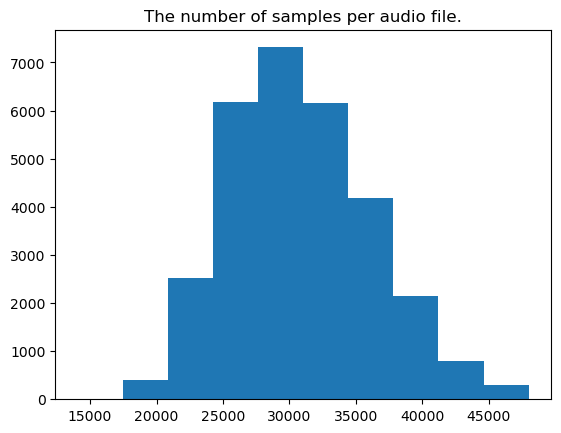

In [4]:
# Here we make sure that all files have the same sample rate.
sample_rates = set()

# We want to plot a histogram of the number of samples in the audio files.
num_samples = [] 

for speaker in dataset:
    for digit in range(10):
        for file in dataset[speaker][digit]:
            sample_rates.add(file.sample_rate)
            num_samples.append(len(file.samples))

max_samples = max(num_samples)
print(f"The sample rates are: {sample_rates}. There should be only one sample rate.")
print("The maximum amount of samples is: ", max(num_samples))
plt.title("The number of samples per audio file.")
plt.hist(num_samples)
plt.show()

### Feature extraction

We resize each signal to 48000 samples before extracting features to make all signals the same dimension.

We split each signal into 12 time windows, and extract 12 mfccs for each time window. We also discard the first mfcc as it
only carries the loudness of the signal.

We are left with 12 time windows of 11 mfccs each. We flatten this matrix to obtain our features.

In [5]:
def extract_features(audio_file, max_duration):
    y = audio_file.samples.astype(np.float32)

    # Resize y to the maximum possible duration.
    y = np.concat([y, np.zeros(max_duration - len(y))]) 
    y /= np.max(audio_file.samples)

    mfccs = librosa.feature.mfcc(y=y, sr=audio_file.sample_rate, n_fft=8192, hop_length=4096, n_mfcc=12)
    mfccs = mfccs[2:, :]

    return mfccs.flatten()

In [6]:
X = []
y = []

for speaker in tqdm(dataset):
    for digit in range(0, 10):
        for audio_file in dataset[speaker][digit]:
            X.append(extract_features(audio_file, 48000))
            y.append(digit)


X = np.array(X)
y = np.array(y)
print(X.shape)

100%|██████████| 60/60 [06:38<00:00,  6.65s/it]

(30000, 120)


In [8]:
np.save("mfcc-features.pkl", X)
np.save("mfcc-labels.pkl", y)

In [3]:
X = np.load("mfcc-features.pkl.npy")
y = np.load("mfcc-labels.pkl.npy")

### MFCC visualization

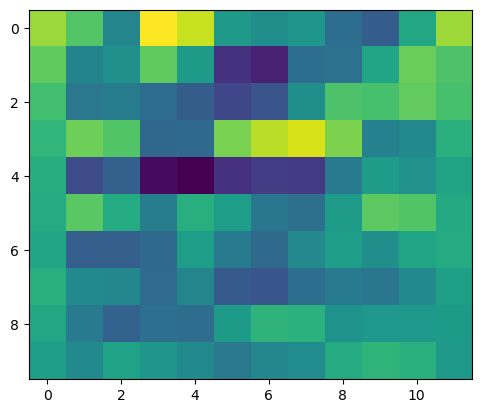

In [4]:
sample = X[202].reshape(10, 12)
plt.imshow(sample)

### Train-test split

Here we split the dataset into train and test sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20100, 120) (20100,)
(9900, 120) (9900,)


### Training set visualization

We visualize the training set using T-SNE.

(20100, 2)


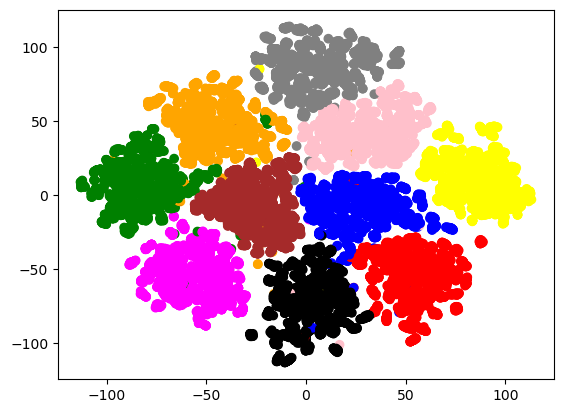

In [6]:
colors = np.array(["red", "green", "blue", "pink", "magenta", "brown", "yellow", "black", "grey", "orange"])

tsne = TSNE(n_components=2)
X_train_transform = tsne.fit_transform(X_train)

print(X_train_transform.shape)
plt.scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[y_train])

### Evaluating models

This function computes various metrics to evaluate the clustering performance. Most importantly, it finds a mapping from the cluster labels to the true labels using the Hungarian algorithm. This is useful because we 
can later report the true accuracy on the test set.

In [7]:
def evaluate_model(model, verbose=False):
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    contingency = contingency_matrix(y_train, predictions_train)

    if verbose:
        print("Rand score on the train set: ", rand_score(y_train, predictions_train))
        print("Adjusted rand score on the train set: ", adjusted_rand_score(y_train, predictions_train))

        print("Rand score on the test set: ", rand_score(y_test, predictions_test))
        print("Adjusted rand score on the test set: ", adjusted_rand_score(y_test, predictions_test))

        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        axs[0].set_title("True labels")
        axs[0].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[y_train])
        axs[1].set_title("Predicted - before alignment")
        axs[1].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[predictions_train])

        plt.show()

        print("Contingency matrix:")
        disp = ConfusionMatrixDisplay(contingency)
        disp.plot()
        plt.show()


    # Compute the best assignment.
    rows, cols = linear_sum_assignment(contingency, maximize=True)
    
    # Now build the mapping.
    mapping = dict([])
    for index in range(len(rows)):
        mapping[int(cols[index])] = int(rows[index])

    updated_predictions_train = np.array(list(mapping[pred] for pred in predictions_train))
    updated_predictions_test= np.array(list(mapping[pred] for pred in predictions_test))

    train_accuracy = accuracy_score(y_train, updated_predictions_train)
    test_accuracy = accuracy_score(y_test, updated_predictions_test)

    if verbose:
        print("Best mapping using the hungarian algorithm: ", mapping)
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
        axs[0].set_title("True labels")
        axs[0].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[y_train])
        axs[1].set_title("Predicted - after alignment")
        axs[1].scatter(X_train_transform[:, 0], X_train_transform[:, 1], c=colors[updated_predictions_train])
        plt.show()

        print("Accuracy of the model after the alignment on the train set: ", train_accuracy)
        print("Accuracy of the model after the alignment on the test set: ", test_accuracy)

    return (train_accuracy, test_accuracy)

### Finding the best Birch model

Here we fit multiple Birch clustering models with various hyperparameters.

In [15]:
params = [{
    "threshold": [0.1],
    "branching_factor": [100],
    "n_clusters" : [
        AgglomerativeClustering(n_clusters=10, linkage="ward"), 
        AgglomerativeClustering(n_clusters=10, linkage="complete"), 
        AgglomerativeClustering(n_clusters=10, linkage="average"), 
        AgglomerativeClustering(n_clusters=10, linkage="single"), 
        ]
},
{
    "threshold": [1, 50, 100, 200],
    "branching_factor": [100],
    "n_clusters": [10]
},
{
    "threshold": [0.1],
    "branching_factor": [50, 20, 10, 3],
    "n_clusters": [10],
},
]

param_grid = ParameterGrid(params)
print(list(param_grid))

def try_params(params):
    model = Birch(**params)
    model.fit(X_train, y_train)

    scores = evaluate_model(model)
    print(f"Birch model with params: {params}, scored: {scores}")
    return params, scores


result = Parallel(n_jobs=4)(delayed(try_params)(param) for param in param_grid)

best_test_accuracy = 0
for args, metrics in result:
    train_accuracy, test_accuracy = metrics 

    if test_accuracy > best_test_accuracy:
        best_args_birch = args
        best_test_accuracy = test_accuracy

print("Best args for birch: ", best_args_birch)


[{'branching_factor': 100, 'n_clusters': AgglomerativeClustering(n_clusters=10), 'threshold': 0.1}, {'branching_factor': 100, 'n_clusters': AgglomerativeClustering(linkage='complete', n_clusters=10), 'threshold': 0.1}, {'branching_factor': 100, 'n_clusters': AgglomerativeClustering(linkage='average', n_clusters=10), 'threshold': 0.1}, {'branching_factor': 100, 'n_clusters': AgglomerativeClustering(linkage='single', n_clusters=10), 'threshold': 0.1}, {'branching_factor': 100, 'n_clusters': 10, 'threshold': 1}, {'branching_factor': 100, 'n_clusters': 10, 'threshold': 50}, {'branching_factor': 100, 'n_clusters': 10, 'threshold': 100}, {'branching_factor': 100, 'n_clusters': 10, 'threshold': 200}, {'branching_factor': 50, 'n_clusters': 10, 'threshold': 0.1}, {'branching_factor': 20, 'n_clusters': 10, 'threshold': 0.1}, {'branching_factor': 10, 'n_clusters': 10, 'threshold': 0.1}, {'branching_factor': 3, 'n_clusters': 10, 'threshold': 0.1}]
Birch model with params: {'branching_factor': 100,

/home/visan/miniconda3/envs/pml-project2/lib/python3.13/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Birch model with params: {'branching_factor': 100, 'n_clusters': 10, 'threshold': 200}, scored: (0.10139303482587064, 0.09717171717171717)
Birch model with params: {'branching_factor': 100, 'n_clusters': AgglomerativeClustering(n_clusters=10), 'threshold': 0.1}, scored: (0.8581094527363184, 0.8618181818181818)
Birch model with params: {'branching_factor': 100, 'n_clusters': 10, 'threshold': 50}, scored: (0.8456218905472637, 0.8506060606060606)
Birch model with params: {'branching_factor': 100, 'n_clusters': 10, 'threshold': 1}, scored: (0.8581094527363184, 0.8618181818181818)
Birch model with params: {'branching_factor': 50, 'n_clusters': 10, 'threshold': 0.1}, scored: (0.8581094527363184, 0.8618181818181818)
Birch model with params: {'branching_factor': 20, 'n_clusters': 10, 'threshold': 0.1}, scored: (0.8581094527363184, 0.8618181818181818)
Birch model with params: {'branching_factor': 10, 'n_clusters': 10, 'threshold': 0.1}, scored: (0.8581094527363184, 0.8618181818181818)
Birch mod

In [18]:
params = [
    {
    "metric": ["euclidean", "cosine"],
    "n_clusters": [10],
    "n_sampling": [3000]
    },
    {
    "max_iter": [200, 300, 400, 500],
    "n_clusters": [10],
    "n_sampling": [3000]
    },
    {
    "n_clusters": [10],
    "n_sampling": [3000, 6000, 8000]
    },
]

param_grid = ParameterGrid(params)
print(list(param_grid))

def try_params(params):
    model = CLARA(**params, random_state=42)
    model.fit(X_train, y_train)

    scores = evaluate_model(model)
    print(f"CLARA model with params: {params}, scored: {scores}")
    return params, scores


result = Parallel(n_jobs=4)(delayed(try_params)(param) for param in param_grid)

best_test_accuracy = 0
for args, metrics in result:
    train_accuracy, test_accuracy = metrics 

    if test_accuracy > best_test_accuracy:
        best_args_clara = args
        best_test_accuracy = test_accuracy

print("Best args for clara: ", best_args_clara)

[{'metric': 'euclidean', 'n_clusters': 10, 'n_sampling': 3000}, {'metric': 'cosine', 'n_clusters': 10, 'n_sampling': 3000}, {'max_iter': 200, 'n_clusters': 10, 'n_sampling': 3000}, {'max_iter': 300, 'n_clusters': 10, 'n_sampling': 3000}, {'max_iter': 400, 'n_clusters': 10, 'n_sampling': 3000}, {'max_iter': 500, 'n_clusters': 10, 'n_sampling': 3000}, {'n_clusters': 10, 'n_sampling': 3000}, {'n_clusters': 10, 'n_sampling': 6000}, {'n_clusters': 10, 'n_sampling': 8000}]
CLARA model with params: {'max_iter': 300, 'n_clusters': 10, 'n_sampling': 3000}, scored: (0.810547263681592, 0.8114141414141414)
CLARA model with params: {'max_iter': 200, 'n_clusters': 10, 'n_sampling': 3000}, scored: (0.810547263681592, 0.8114141414141414)
CLARA model with params: {'metric': 'euclidean', 'n_clusters': 10, 'n_sampling': 3000}, scored: (0.810547263681592, 0.8114141414141414)
CLARA model with params: {'metric': 'cosine', 'n_clusters': 10, 'n_sampling': 3000}, scored: (0.7864676616915423, 0.7861616161616162